### Dementia Prediction

Using MRI data from patients w/ and w/o Alzheimier's, develop model that can predict if a patient is demented

Based on: https://www.kaggle.com/ruslankl/dementia-prediction-w-tree-based-models

In [1]:
import os
import sys

# Set project path
parent_project_name = 'Python_Notebooks_For_Machine_Learning'
path = os.getcwd()
parent_project_name = path[0: path.index(parent_project_name) + len(parent_project_name)]

# Import dex.py library
sys.path.insert(0, parent_project_name + os.sep + 'common')
import dex

In [2]:
import pandas as pd
import numpy as np
from functools import reduce
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


# Import data to dataframe
data_dir = os.path.join(parent_project_name,'Projects', 'DementiaPrediction','data')
cs_df = pd.read_csv(os.path.join(data_dir,'oasis_cross-sectional.csv'), index_col='ID')
long_df = pd.read_csv(os.path.join(data_dir,'oasis_longitudinal.csv'), index_col=['Subject ID', 'MRI ID'])
dex.set_columns_to_category_dtype(cs_df)
dex.set_columns_to_category_dtype(long_df)

long_df['Group_enum'] = dex.enumerate_column(long_df['Group'])

In [4]:
cs_df.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
ID,,,,,,,,,,,
OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [5]:
long_df.head()

Group  Visit  MR Delay M/F Hand  Age  EDUC  \
Subject ID MRI ID                                                            
OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87    14   
           OAS2_0001_MR2  Nondemented      2       457   M    R   88    14   
OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75    12   
           OAS2_0002_MR2     Demented      2       560   M    R   76    12   
           OAS2_0002_MR3     Demented      3      1895   M    R   80    12   

                          SES  MMSE  CDR  eTIV   nWBV    ASF Group_enum  
Subject ID MRI ID                                                        
OAS2_0001  OAS2_0001_MR1  2.0  27.0  0.0  1987  0.696  0.883          0  
           OAS2_0001_MR2  2.0  30.0  0.0  2004  0.681  0.876          0  
OAS2_0002  OAS2_0002_MR1  NaN  23.0  0.5  1678  0.736  1.046          1  
           OAS2_0002_MR2  NaN  28.0  0.5  1738  0.713  1.010          1  
           OAS2_0002_MR3  NaN  22.0  0.5  1698  0.701  1.034          1

In [9]:
cs_df.describe()

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
count,436.000000,235.000000,216.000000,235.00000,235.000000,436.000000,436.000000,436.000000,20.00000
mean,51.357798,3.178723,2.490741,27.06383,0.285106,1481.919725,0.791670,1.198894,20.55000
std,25.269862,1.311510,1.120593,3.69687,0.383405,158.740866,0.059937,0.128682,23.86249
min,18.000000,1.000000,1.000000,14.00000,0.000000,1123.000000,0.644000,0.881000,1.00000
25%,23.000000,2.000000,2.000000,26.00000,0.000000,1367.750000,0.742750,1.111750,2.75000
50%,54.000000,3.000000,2.000000,29.00000,0.000000,1475.500000,0.809000,1.190000,11.00000
75%,74.000000,4.000000,3.000000,30.00000,0.500000,1579.250000,0.842000,1.284250,30.75000
max,96.000000,5.000000,5.000000,30.00000,2.000000,1992.000000,0.893000,1.563000,89.00000


In [10]:
long_df.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


In [3]:
cs_continuous, cs_categorical, cs_error = dex.get_data_quality_report(cs_df)
cs_continuous
cs_categorical

,Hand,M/F
count,436,436
nulls,0,0
nulls pct,0.00,0.00
mode,R,F
mode count,436,268
mode pct,1.00,0.61
2nd mode,NaN,M
2nd mode count,NaN,168
2nd mode pct,NAN,0.39
cardinality,1,2


In [4]:
long_continuous, long_categorical, long_error = dex.get_data_quality_report(long_df)
long_continuous

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373,373,373,373,373,373,373,373,373,373
nulls,0,0,0,0,19,2,0,0,0,0
nulls pct,0.00,0.00,0.00,0.00,0.05,0.01,0.00,0.00,0.00,0.00
std,0.922843,635.485,7.64096,2.87634,1.134,3.68324,0.374557,176.139,0.037135,0.138092
min,1,0,60,6,1,4,0,1106,0.644,0.876
25%,1,0,71,12,2,27,0,1357,0.7,1.099
50%,2,552,77,15,2,29,0,1470,0.729,1.194
mean,1.88204,595.105,77.0134,14.5979,2.46045,27.3423,0.290885,1488.13,0.729568,1.19546
75%,2,873,82,16,3,30,0.5,1597,0.756,1.293
max,5,2639,98,23,5,30,2,2004,0.837,1.587


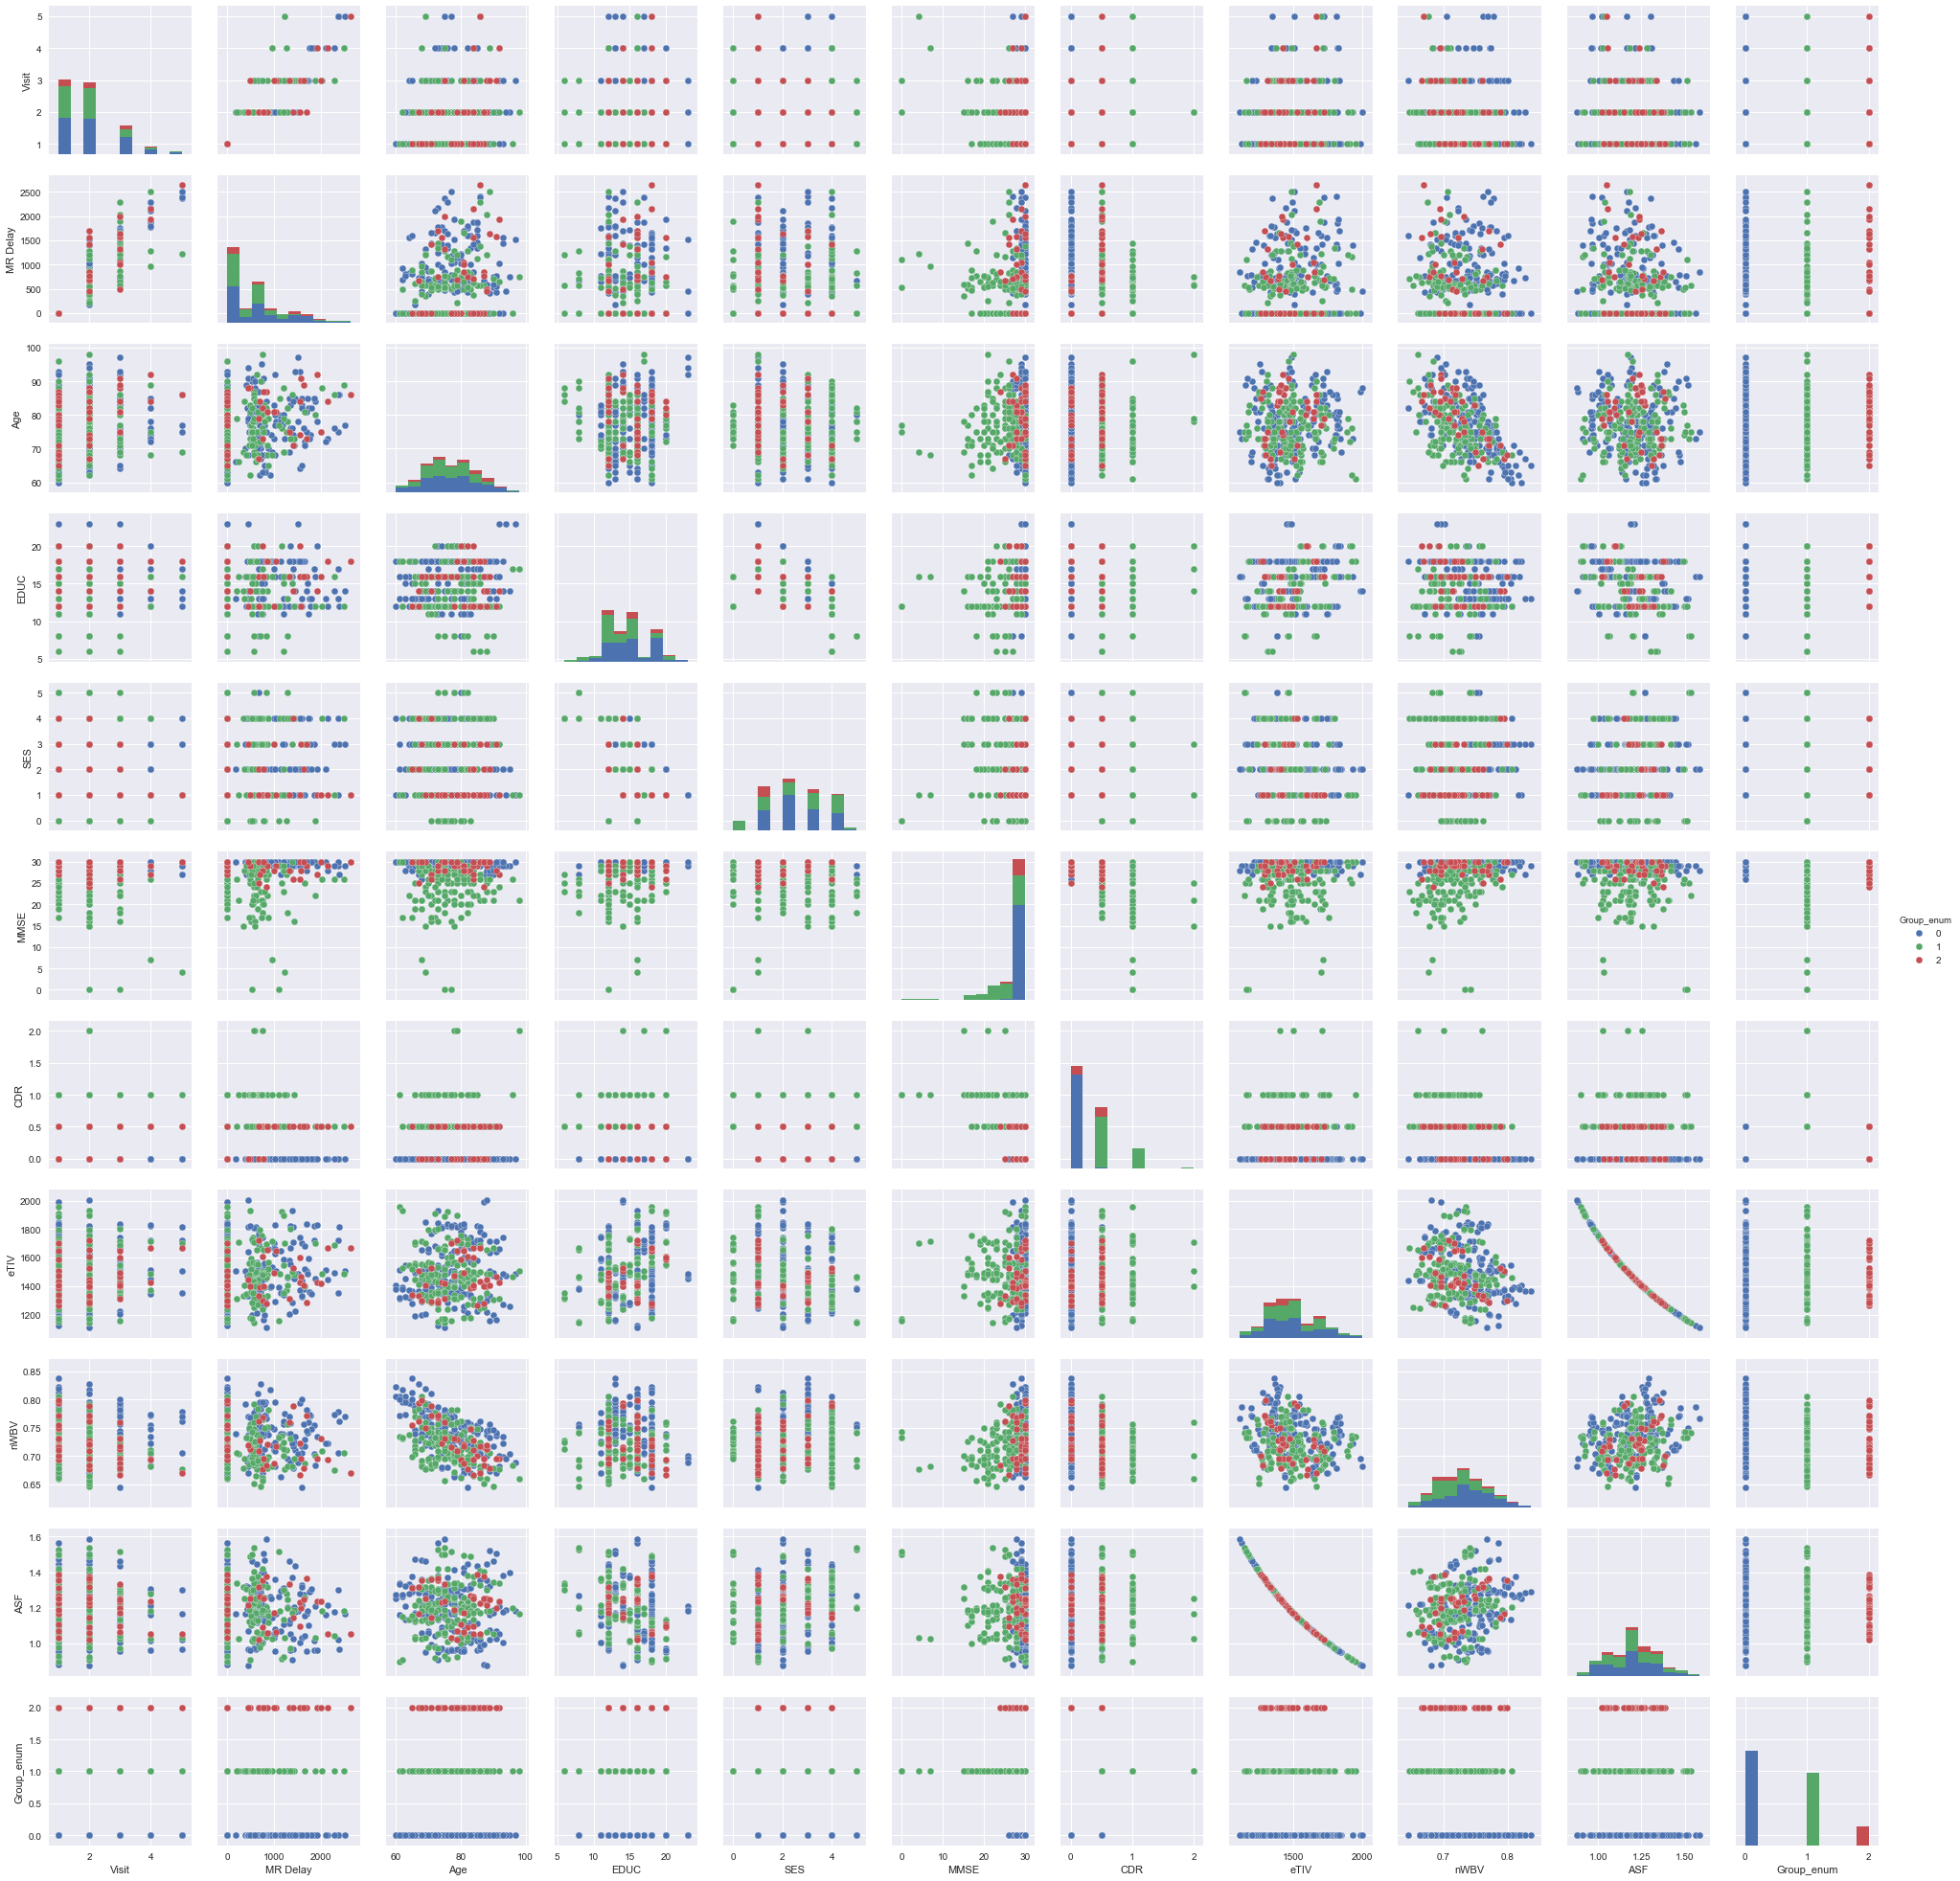

In [4]:
sns.pairplot(data=long_df.select_dtypes(include=[np.number]).fillna(0),hue='Group_enum')
plt.show()

In [3]:
long_df.dtypes

Group         category
Visit            int64
MR Delay         int64
M/F           category
Hand          category
Age              int64
EDUC             int64
SES            float64
MMSE           float64
CDR            float64
eTIV             int64
nWBV           float64
ASF            float64
Group_enum       int64
dtype: object

Subject ID  MRI ID       
OAS2_0001   OAS2_0001_MR1    0
            OAS2_0001_MR2    0
OAS2_0002   OAS2_0002_MR1    1
            OAS2_0002_MR2    1
            OAS2_0002_MR3    1
OAS2_0004   OAS2_0004_MR1    0
            OAS2_0004_MR2    0
OAS2_0005   OAS2_0005_MR1    0
            OAS2_0005_MR2    0
            OAS2_0005_MR3    0
OAS2_0007   OAS2_0007_MR1    1
            OAS2_0007_MR3    1
            OAS2_0007_MR4    1
OAS2_0008   OAS2_0008_MR1    0
            OAS2_0008_MR2    0
OAS2_0009   OAS2_0009_MR1    1
            OAS2_0009_MR2    1
OAS2_0010   OAS2_0010_MR1    1
            OAS2_0010_MR2    1
OAS2_0012   OAS2_0012_MR1    0
            OAS2_0012_MR2    0
            OAS2_0012_MR3    0
OAS2_0013   OAS2_0013_MR1    0
            OAS2_0013_MR2    0
            OAS2_0013_MR3    0
OAS2_0014   OAS2_0014_MR1    1
            OAS2_0014_MR2    1
OAS2_0016   OAS2_0016_MR1    1
            OAS2_0016_MR2    1
OAS2_0017   OAS2_0017_MR1    0
                            ..
OAS2_0175   O